# Xplique : 
Dans ce notebook je vais présenter la bibliothèque Xplique.
Je vais me concentrer sur la classification d'image. 
On travail surtout sur de l'explicabuilité Local. 
Le but de ce notebook ce n'est pas de détailler toutes les méthodes d'explicabilité mais c'est d'explorer l'API qui va faciliter l'utilisation de ces techniques. 

# Attribution Method

Les méthodes d'attributions sont des techniques d'expliquabilité pour en particulier les réseau Deep Learning. Ces méthodes vont attribuer à des pixels ou des groupes de pixels sur l'image, l'importance du pixel ou de ce groupe sur une prédiction donnée.
L'API Xplique propose une implémentation de 14 d'entres elles. Cette API va proposer une syntaxe simple pour l'implémentation de ces techniques.
On distingue 2 types de méthodes : 
- **Perturbation-based approaches** : Les méthodes basées sur la perturbation se concentrent sur la perturbation d'une entrée avec une variété de techniques et, avec l'analyse des sorties résultantes, définissent une représentation d'attribution. Il n'est donc pas nécessaire de connaître explicitement l'architecture du modèle tant que la transmission est disponible, ce qui explique pourquoi ces méthodes sont également appelées « boîtes noires ». 
    - Par exemple, on a vu la méthode lime qui va segementer l'image en super-pixel (gros groupement de pixel), ensuite à partir de l'image qu'on veut expliquer, on va créer une multitude d'autre input en masquant certain super-pixels ou non. Ensuite à partir de la prédiction des ces inputs généré on va déterminer les pixels avec le plus grand intérêt. 
<img src="images/lime_explication.jpg">

- **Gradient-based approaches** : Ces approches sont également appelées "white box methods", car elles nécessitent un accès complet à l'architecture du modèle, qui doit notamment permettre de calculer les gradients. En effet, l'idée centrale des approches basées sur le gradient est d'utiliser la rétropropagation, non pas pour mettre à jour les poids du modèle (qui est déjà entraîné), mais pour révéler les entrées les plus contributives, potentiellement dans une couche spécifique.
    - Example avec la méthodes GradCAM : 


## Implémentation de l'API

On va implementer notre API. Il nous faut donc des modèles déja entrainé sur lequel on va appliquer nos méthodes d'explicabilité. 
Déclaration dans Xplique. 
```
explainer = Method(model, batch_size, operator)
explanation = explainer(inputs, targets)
```
L'API de Xplique est plutôt simple pour l'utiliser. On définit un ```explainer``` qui est une instance de ```Method```. ```Method``` : est l'une des méthode d'explicabilité comme ```GradCAM``` ou ```Lime```.
- ```model``` : est le modèle qu'on va utiliser pour nos prédiction. Nous travaillerons sur 2 modèles différents. Le premier est MobileNetV2 implémenter directement dans tensorflow. Le deuxième est aircraft_model, c'est un modèle qu'on a entrainé dans le cours sur les CNN pour reconaître ou non des avions avec des images satélites. Ce dernier modèle à une précision de 90% et n'a pas été beaucoup entrainé, ansi il nous permettra de mieux visualiser les méthodes.
- ```batch_size``` : Pour les méthodes *Gradient-based*, on peut calculer les gradients par batch. C'est donc la taille du batch qu'on précise ici.
- ```operator``` : C'est la tache du model (Classification, Object Detection, Regression et Segmantic Segmentation). On choisi de travailler que avec des Classifier, on ne précisera donc rien dans ```operator```.

Ensuite on appel le ```explainer```. On veut donc expliquer quel pixel contribue à associer des classes dans target à des images dans input. A noter que dans target on est pas obligé de donner la classe la plus probable donné par notre modèle.  

Ensuite pour chaque méthode on aura des paramètres suplémentaires spécifique à la méthode. Par exemple pour ```Lime``` on aura ```nb_sample```, le nombre d'image perturber à généré. 


In [2]:
# Import et install
!pip install -q xplique

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from math import ceil
import cv2

%matplotlib inline
%config InlineBackend.figure_format='retina'

import xplique
from xplique.plots import plot_attributions

import tensorflow.keras.applications as app


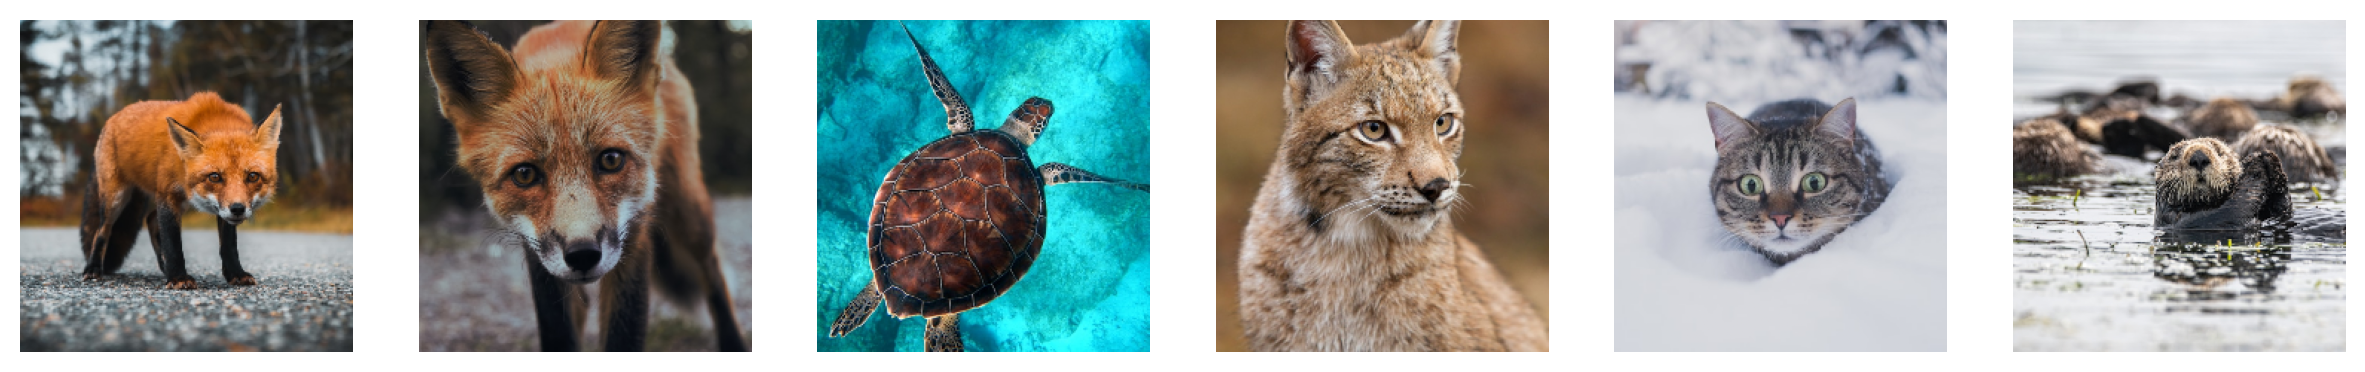

In [3]:
# Décomenter pour télécharger les images dans ./data/
# downloading image from unsplash...
# !wget -nv 'https://unsplash.com/photos/X2PwqTUpXH8/download?force=true&w=640' -O './data/fox1.jpg'
# !wget -nv 'https://unsplash.com/photos/tIfrzHxhPYQ/download?force=true&w=640' -O './data/fox2.jpg'
# !wget -nv 'https://unsplash.com/photos/LVnJlyfa7Zk/download?force=true&w=640' -O './data/sea_turtle.jpg'
# !wget -nv 'https://unsplash.com/photos/sSEEbAzB6fU/download?force=true&w=640' -O './data/lynx.jpg'
# !wget -nv 'https://unsplash.com/photos/41dAczoRYJY/download?force=true&w=640' -O './data/cat.jpg'
# !wget -nv 'https://unsplash.com/photos/axqTLZ12Jss/download?force=true&w=640' -O './data/otter.jpg'

img_list = [
    ('./data/fox1.jpg', 277),
    ('./data/fox2.jpg', 277),
    ('./data/sea_turtle.jpg', 33),
    ('./data/lynx.jpg', 287),
    ('./data/cat.jpg', 281),
    ('./data/otter.jpg', 360)
]

def central_crop_and_resize(img, size=224):
  """
  Given a numpy array, extracts the largest possible square and resizes it to
  the requested size (224x224 pour MobileNetV2)
  Notre modèle qu'on utilise est MobileNetV2 qui prend des images de taille 224x224, on doit donc redimensioner
  nos images
  """
  h, w, _ = img.shape

  min_side = min(h, w)
  max_side_center = max(h, w) // 2.0

  min_cut = int(max_side_center-min_side//2)
  max_cut = int(max_side_center+min_side//2)

  img = img[:, min_cut:max_cut] if w > h else img[min_cut:max_cut]
  img = tf.image.resize(img, (size, size))

  return img

X = []
Y = []

for img_name, label in img_list:
    img = cv2.imread(img_name)[..., ::-1] # when cv2 load an image, the channels are inversed
    img = central_crop_and_resize(img)
    label = tf.keras.utils.to_categorical(label, 1000)

    X.append(img)
    Y.append(label)

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.int8)

plt.rcParams["figure.figsize"] = [15, 6]
for img_id, img in enumerate(X):
  plt.subplot(1, len(X), img_id+1)
  plt.imshow(img/255.0)
  plt.axis('off')


In [4]:
# load the model and preprocess the inputs (adapt the input range)
model, preprocessing = app.MobileNetV2(), app.mobilenet_v2.preprocess_input
X_preprocessed = tf.convert_to_tensor(preprocessing(np.array(X, copy=True)))


In [ ]:
from xplique.attributions import GradCAM, Lime, KernelShap

explainer = KernelShap(model, nb_samples=500)
explanations = explainer(X_preprocessed, Y)

# plot the attribution on top of the image
for i in range(len(X)):
  plt.subplot(1, len(X), i+1)
  plt.imshow(X[i]/255.0)
  plt.imshow(explanations[i], cmap="jet", alpha=0.5)
  plt.axis('off')

2025-02-09 15:06:20.061921: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 308281344 exceeds 10% of free system memory.
2025-02-09 15:06:20.148995: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 313810944 exceeds 10% of free system memory.
2025-02-09 15:06:21.097548: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 308281344 exceeds 10% of free system memory.
2025-02-09 15:06:21.181054: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 313810944 exceeds 10% of free system memory.
2025-02-09 15:06:22.841534: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 308281344 exceeds 10% of free system memory.


On peut maintenant prendre autant de méthode que l'on veut et comparer leur résultat.

In [68]:
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients, SmoothGrad, VarGrad,
                                  SquareGrad, GradCAM, Occlusion, Rise, GuidedBackprop,
                                  GradCAMPP, Lime, KernelShap, SobolAttributionMethod)

Method: GradCAM


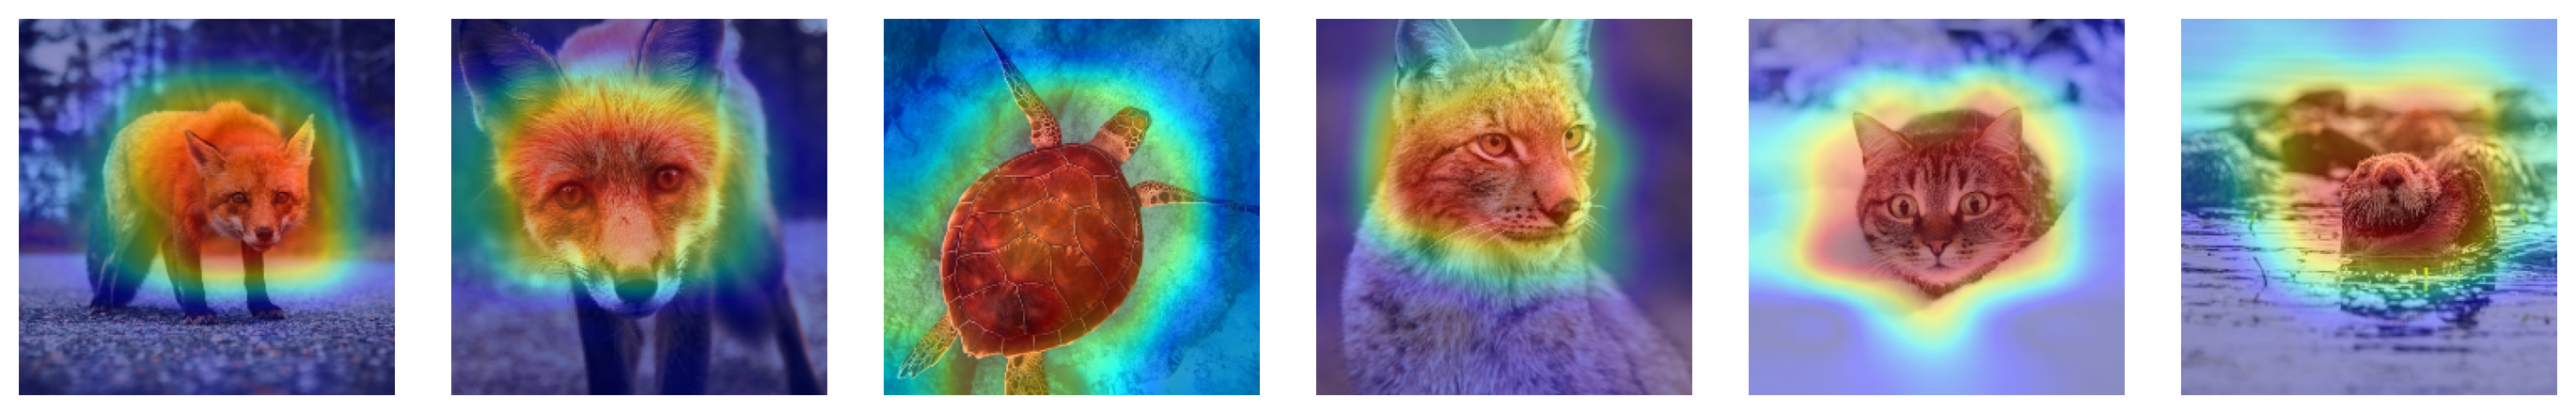

KeyboardInterrupt: 

In [69]:
# La dernière couche d'activation est normalement un softmax qui permet d'avoir une distribution de probabilité
# pour chaque classe. On retire la fonction d'activation pour la remplacer par du linéaire. 
# On fait cela car les méthodes Gradient-Base regarde pourquoi tel ou tel neuronne est maximisé (donc avant softmax) et 
# non pourquoi telle ou tel neuronne à la plus grande probabilité d'être choisi (après softmax)
model.layers[-1].activation = tf.keras.activations.linear
batch_size = 64

explainers = [
            #  Saliency(model),
            #  GradientInput(model),
            #  GuidedBackprop(model),
            #  IntegratedGradients(model, steps=80, batch_size=batch_size),
            #  SmoothGrad(model, nb_samples=80, batch_size=batch_size),
            #  SquareGrad(model, nb_samples=80, batch_size=batch_size),
            #  VarGrad(model, nb_samples=80, batch_size=batch_size),
             GradCAM(model),
             Occlusion(model, patch_size=10, patch_stride=5, batch_size=batch_size),
            #  Rise(model, nb_samples=4000, batch_size=batch_size),
            #  SobolAttributionMethod(model, batch_size=batch_size)
            #  Lime(model, nb_samples = 100),
            #  KernelShap(model, nb_samples = 1000)
]

for explainer in explainers:

  explanations = explainer(X_preprocessed, Y)

  print(f"Method: {explainer.__class__.__name__}")
  plot_attributions(explanations, X, img_size=2., cmap='jet', alpha=0.4,
                    cols=len(X), absolute_value=True, clip_percentile=0.5)
  plt.show()
  print("\n")

On va maintenant tester sur notre modèle de aircraft

In [71]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import cv2

In [72]:
TOY_DATASET_URL = "https://storage.googleapis.com/fchouteau-isae-deep-learning/toy_aircraft_dataset_2023.npz"

ds = np.lib.npyio.DataSource(destpath="/tmp/")
f = ds.open(TOY_DATASET_URL, "rb")
toy_dataset = np.load(f)

trainval_images : np.ndarray = toy_dataset["train_images"]
trainval_labels : np.ndarray = toy_dataset["train_labels"]
test_images : np.ndarray = toy_dataset["test_images"]
test_labels : np.ndarray = toy_dataset["test_labels"]
trainval_images.shape, test_images.shape

((2688, 64, 64, 3), (896, 64, 64, 3))

In [73]:
# On charge notre modèle déjà entrainé
aircraft_model = tf.keras.models.load_model("./model/aircraft_model.h5")
aircraft_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        9248      
                                                      

On définit le preprocessing en normalisant les images sur 0..1 et en normalisant par la moyenne et l'écart type du data set d'entrainement (calculé plus tôt)

In [74]:
def preprocessing(image) :
    mean = np.array([0.33012513, 0.34202802, 0.32268534])
    std = np.array([0.16872728, 0.16531856, 0.16314243])
    # Normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Standardize using the mean and std of the dataset
    image = (image - mean) / std

    return image

In [75]:
test_images_norm = preprocessing(np.array(test_images, copy=True))
test_loss, test_acc = aircraft_model.evaluate(test_images_norm, test_labels)
print(f"Test accuracy: {test_acc}")

28/28 [==============================] - 1s 14ms/step - loss: 0.6782 - accuracy: 0.9051
Test accuracy: 0.9051339030265808


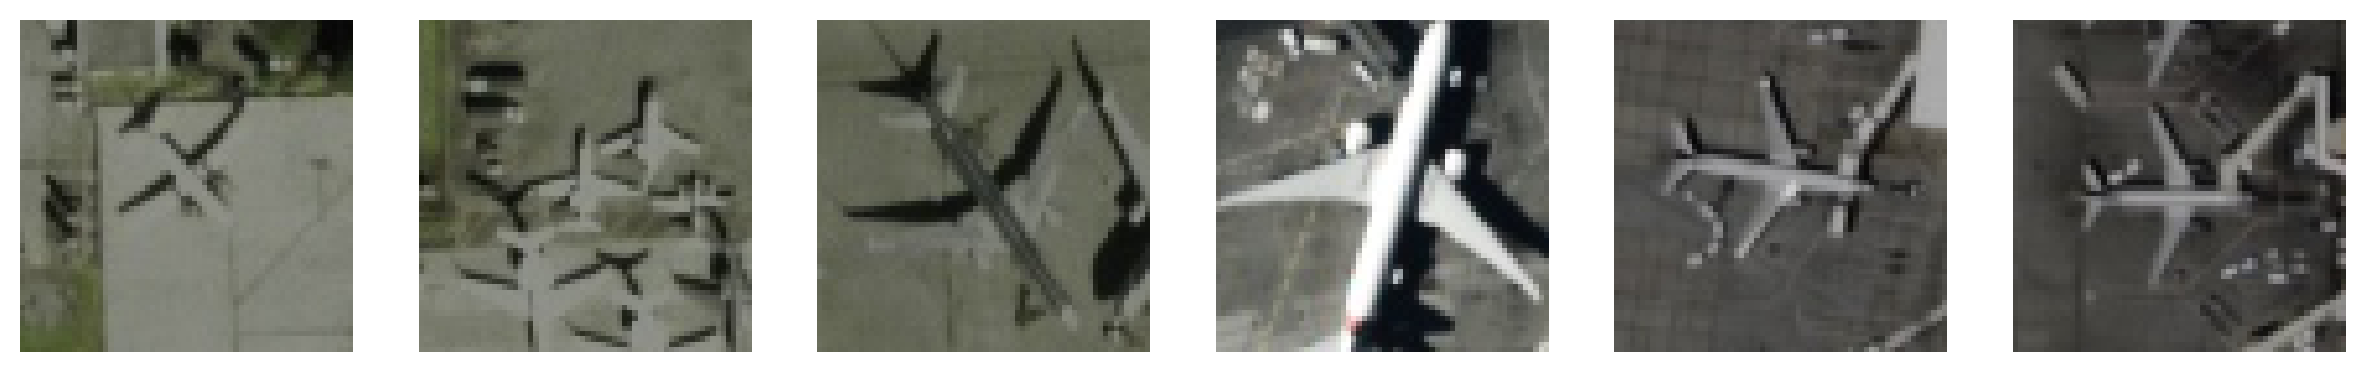

In [76]:
# Un peu de data visualisation
# On affiche les images dans lequels c'est un aircraft
# test_images[test_labels == 1][:6]

X = test_images[test_labels == 1][27:33]
Y = np.ones(X.shape[0])
plt.rcParams["figure.figsize"] = [15, 6]
for img_id, img in enumerate(X):
  plt.subplot(1, len(X), img_id+1)
  plt.imshow(img/255.0)
  plt.axis('off')


In [89]:
X_preprocessed = preprocessing(np.array(X, copy=True))
output = aircraft_model.predict(X_preprocessed)
# output >= 0.5
X_preprocessed.shape, Y.shape, output >= 0.5
Y[2] = 1
Y

1/1 [==============================] - 0s 43ms/step


array([1., 1., 1., 1., 1., 1.])

In [99]:
explainer = Occlusion(aircraft_model)
explanations = explainer(X_preprocessed, Y)

plt.rcParams["figure.figsize"] = [15, 6]

for i in range(len(X)):
    plt.subplot(1, len(X), i + 1)
    plt.imshow(X[i])
    heatmap = plt.imshow(explanations[i], cmap="jet", alpha=0.5)
    plt.axis('off')

    # Add a color bar to the last subplot
    if i == len(X) - 1:
        plt.colorbar(heatmap, fraction=0.046, pad=0.04)

plt.show()

2025-02-09 14:54:57.835299: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: Attempting to slice scalar input.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Attempting to slice scalar input. [Op:StridedSlice] name: strided_slice/

Method: Saliency


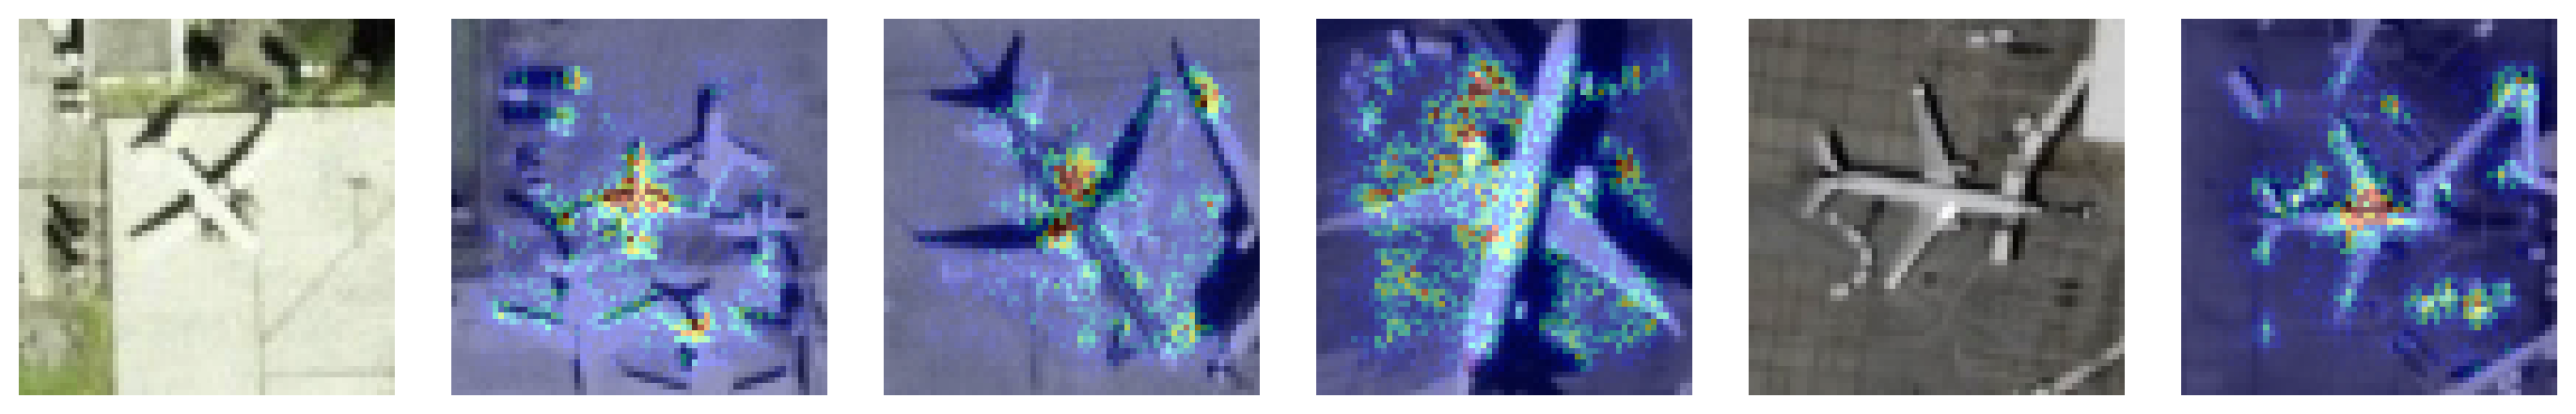



Method: GradientInput


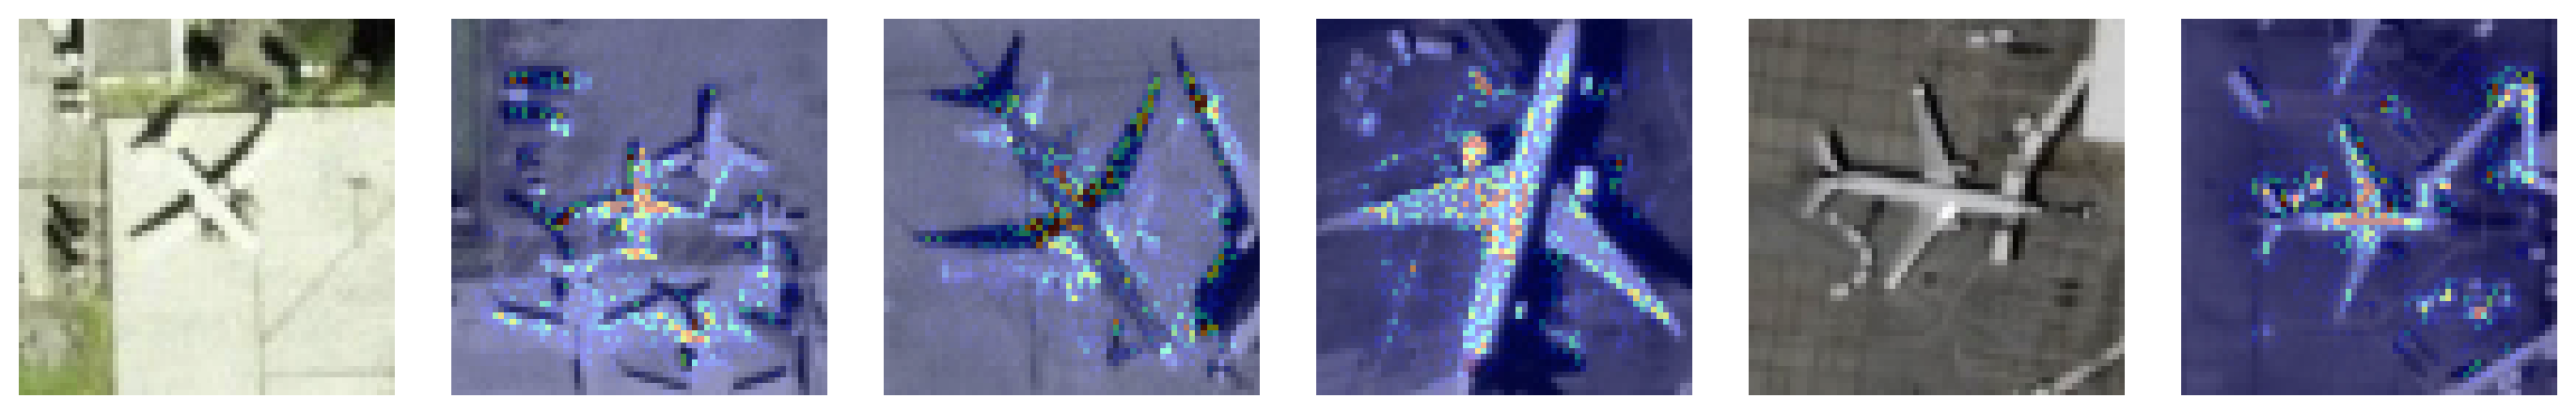



Method: GradCAM


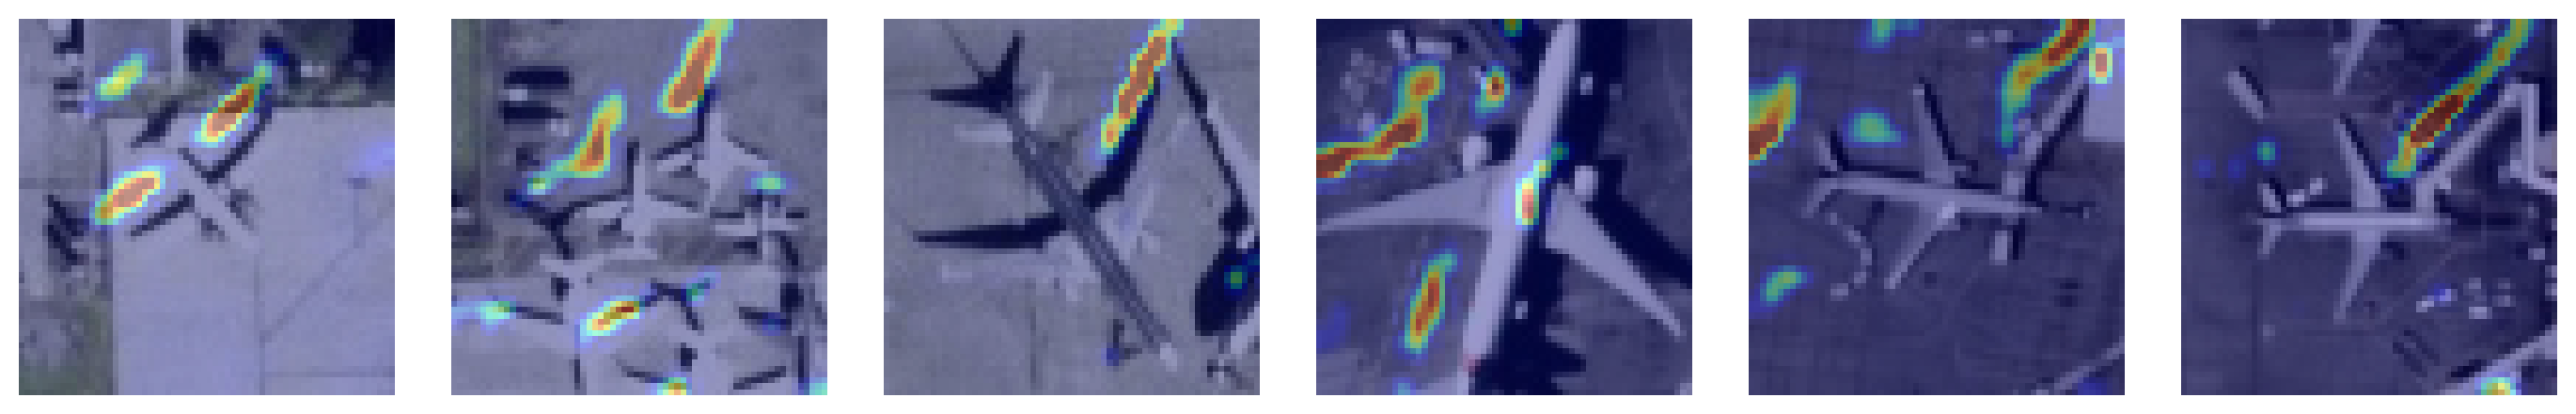

2025-02-09 14:54:38.163632: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: Attempting to slice scalar input.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Attempting to slice scalar input. [Op:StridedSlice] name: strided_slice/

In [98]:
aircraft_model.layers[-1].activation = tf.keras.activations.linear
batch_size = 64

explainers = [
             Saliency(aircraft_model),
             GradientInput(aircraft_model),
            #  GuidedBackprop(model),
            #  IntegratedGradients(model, steps=80, batch_size=batch_size),
            #  SmoothGrad(model, nb_samples=80, batch_size=batch_size),
            #  SquareGrad(model, nb_samples=80, batch_size=batch_size),
            #  VarGrad(model, nb_samples=80, batch_size=batch_size),
             GradCAM(aircraft_model),
             Occlusion(aircraft_model, patch_size=10, patch_stride=5),
            #  Rise(model, nb_samples=4000, batch_size=batch_size),
            #  SobolAttributionMethod(model, batch_size=batch_size)
            #  Lime(model, nb_samples = 100),
            #  KernelShap(model, nb_samples = 1000)
]

for explainer in explainers:

  explanations = explainer(X_preprocessed, Y)

  print(f"Method: {explainer.__class__.__name__}")
  plot_attributions(explanations, X, img_size=2., cmap='jet', alpha=0.4,
                    cols=len(X), absolute_value=True, clip_percentile=0.5)
  plt.show()
  print("\n")